In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Loading NYT time series data
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/nyt_ts_df.csv')
ts_df = ts_df.groupby(['words','year','property','count']).outputs_z.mean().reset_index()


#Loading NYT sentiment data
sentiment_df = pd.read_csv('./data/SWOW_prediction/eval/nyt_sentiments.csv')

#Merging time series and sentiment data
ts_df = ts_df.merge(sentiment_df, on=['words','year'], how='left')

In [3]:
#Loading the price data

#Downalod from: https://www.bls.gov/cpi/factsheets/average-prices.htm

def get_price_df():

    item_category = {
    'Ice cream':'ice cream',
    'Malt beverages': 'beer',
    'All uncooked ground beef':'beef',
    'All Uncooked Beef Roasts':'beef',
    'All Uncooked Beef Steaks':'steak',
    'All Uncooked Other Beef (Excluding Veal)':'other beef',
    'All Ham (Excluding Canned Ham and Luncheon Slices)':'ham',
    'All Pork Chops':'pork',
    'All Other Pork (Excluding Canned Ham and Luncheon Slices)':'pork',
    'Automotive diesel fuel':'diesel',
    'Cucumbers':'cucumber',
    'Peaches':'peach',
    'Potato chips':'chips',
    'Electricity per KWH': 'electricity',
    'Cookies':'cookie',
    'Ground chuck':'beef',
    'Ground beef':'beef',
    'Chuck roast':'beef',
    'Round roast':'beef',
    'Rib roast':'beef',
    'Steak':'steak',
    'Chops':'pork',
    'Pork sirloin roast':'pork',
    'Shoulder picnic':'pork',
    'Lamb and mutton':'lamb',
    'Chicken breast':'chicken',
    'Chicken legs':'chicken',
    'Eggs':'egg',
    'American processed cheese':'cheese',
    'Cheddar cheese':'cheese',
    'Apples':'apple',
    'Bananas':'banana',
    'Oranges':'orange',
    'Lemons':'lemon',
    'Pears':'pear',
    'Strawberries':'strawberry',
    'Grapes':'grape',
    'Cherries':'cherry',
    'Potatoes':'potatoe',
    'Tomatoes':'tomatoe',
    'Carrots':'carrot',
    'Onions':'onion',
    'Radishes':'radish',
    'Peppers':'pepper',
    'Corn on the cob':'corn',
    'Beans':'bean',
    }
    cpi = pd.read_csv('./data/cpi.csv') #contains product names
    cpi2 = pd.read_csv('./data/cpi2.csv') #monthy prices

    cpi = cpi2.set_index('Series ID').\
    join(cpi.set_index('Series ID')['Item']).reset_index().dropna()

    cpi['words'] = cpi.Item.apply(lambda x : x.split(',')[0] )
    cpi['words'] = cpi.words.apply(lambda x : x.lower() if x not in item_category else item_category[x]) #Matching products to searchable words



    cpi = pd.melt(cpi, id_vars = ['Item','words','Series ID'])
    cpi['year'] = cpi.variable.apply(lambda x : int(x.split(' ')[1]))

    cpi.value = cpi.value.apply(lambda x : float(x) if len(x.strip()) > 0 else None) #Value is price

    cpi = cpi.dropna().reset_index(drop = True) 


    cpi = cpi.groupby(['Item','words','Series ID','year','variable']).value.mean().reset_index() #Averaging prices per month to get price per year

    df2 = cpi.copy(deep = True)
    df2.variable = df2.variable.apply(lambda x : x.split()[0] + ' ' + str(int(x.split()[1]) + 1))
    df2.year = df2.year + 1

    #Creating a new column with the price of the next year
    cpi = cpi.set_index(['Item','words','Series ID','year','variable']).join(\
    df2.set_index(['Item','words','Series ID','year','variable']), lsuffix = '_2',rsuffix = '_1').reset_index()


    cpi = cpi.groupby(['Item','words','Series ID','year'])[['value_1','value_2']].mean().reset_index().dropna()

    cpi['value_change'] = cpi.value_2 / cpi.value_1 - 1 #relative price change between two consequtive years

    return cpi
        
        

        
    











    




In [4]:
cpi = get_price_df()

In [5]:
cpi

,Item,words,Series ID,year,value_1,value_2,value_change
1,All Ham (Excluding Canned Ham and Luncheon Sli...,ham,APU0000FD2101,1999,2.072750,2.055750,-0.008202
2,All Ham (Excluding Canned Ham and Luncheon Sli...,ham,APU0000FD2101,2000,2.055750,2.139500,0.040739
3,All Ham (Excluding Canned Ham and Luncheon Sli...,ham,APU0000FD2101,2001,2.139500,2.219333,0.037314
4,All Ham (Excluding Canned Ham and Luncheon Sli...,ham,APU0000FD2101,2002,2.219333,2.249250,0.013480
5,All Ham (Excluding Canned Ham and Luncheon Sli...,ham,APU0000FD2101,2003,2.249250,2.158250,-0.040458
...,...,...,...,...,...,...,...
1814,"Yogurt, natural, fruit flavored, per 8 oz. (22...",yogurt,APU0000710122,1997,0.650333,0.661333,0.016914
1816,"Yogurt, natural, fruit flavored, per 8 oz. (22...",yogurt,APU0000710122,2000,0.685500,0.693909,0.012267
1817,"Yogurt, natural, fruit flavored, per 8 oz. (22...",yogurt,APU0000710122,2001,0.693909,0.645000,-0.070483
1818,"Yogurt, natural, fruit flavored, per 8 oz. (22...",yogurt,APU0000710122,2002,0.645000,0.679333,0.053230


In [7]:
cpi.loc[cpi.words =='beef'].Item.unique()

array(['All Uncooked Beef Roasts, per lb. (453.6 gm)',
       'All uncooked ground beef, per lb. (453.6 gm)',
       'Chuck roast, USDA Choice, bone-in, per lb. (453.6 gm)',
       'Chuck roast, USDA Choice, boneless, per lb. (453.6 gm)',
       'Chuck roast, graded and ungraded, excluding USDA Prime and Choice, per lb. (453.6 gm)',
       'Ground beef, 100% beef, per lb. (453.6 gm)',
       'Ground beef, lean and extra lean, per lb. (453.6 gm)',
       'Ground chuck, 100% beef, per lb. (453.6 gm)',
       'Rib roast, USDA Choice, bone-in, per lb. (453.6 gm)',
       'Round roast, USDA Choice, boneless, per lb. (453.6 gm)',
       'Round roast, graded and ungraded, excluding USDA Prime and Choice, per lb. (453.6 gm)'],
      dtype=object)

In [8]:
items = cpi.words.unique()
ts_df = ts_df.loc[ts_df.words.isin(items)].reset_index(drop = True)

#Calculating the relative moral association change between two consequtive years
new_df = ts_df.copy(deep = True)
new_df['year'] = new_df.year + 1
change_df = ts_df.set_index(['words','year','property']).\
join(new_df.set_index(['words','year','property']), lsuffix = '_2',rsuffix = '_1').reset_index()
change_df

,words,year,property,count_2,outputs_z_2,sentiments_2,count_1,outputs_z_1,sentiments_1
0,apple,1987,polarity,2539.0,0.123073,0.201687,NaN,NaN,NaN
1,apple,1987,previous_link,2539.0,-1.376371,0.201687,NaN,NaN,NaN
2,apple,1988,polarity,2557.0,0.111513,0.195561,2539.0,0.123073,0.201687
3,apple,1988,previous_link,2557.0,-1.357751,0.195561,2539.0,-1.376371,0.201687
4,apple,1989,polarity,3056.0,0.109784,0.151913,2557.0,0.111513,0.195561
...,...,...,...,...,...,...,...,...,...
2185,yogurt,2005,previous_link,269.0,0.082218,0.254539,225.0,0.112264,0.230889
2186,yogurt,2006,polarity,328.0,0.404199,0.187258,269.0,0.375797,0.254539
2187,yogurt,2006,previous_link,328.0,0.124624,0.187258,269.0,0.082218,0.254539
2188,yogurt,2007,polarity,232.0,0.425429,0.311726,328.0,0.404199,0.187258


In [9]:
#Merging the moral association data with the price data

joint_df = change_df.set_index(['words','year']).\
join(cpi.set_index(['words','year'])).dropna().reset_index()

In [10]:

joint_df['moral_change'] = joint_df['outputs_z_2'] - joint_df['outputs_z_1']


In [19]:
r_df = joint_df.loc[joint_df.property == 'previous_link'] #Moral Relevance data
p_df = joint_df.loc[joint_df.property == 'polarity'] #Moral Polarity data

#Merging the two dataframes
final_df = r_df.set_index(['words','year','Item','Series ID','value_change','value_1','value_2','count_2','count_1','sentiments_1','sentiments_2']).join(\
p_df.set_index(['words','year','Item','Series ID','value_change','value_1','value_2','count_2','count_1','sentiments_1','sentiments_2']), lsuffix = '_relevance',
    rsuffix = '_polarity').reset_index()
final_df['sentiment_change'] = final_df['sentiments_2'] - final_df['sentiments_1']
final_df.sample(2)

,words,year,Item,Series ID,value_change,value_1,value_2,count_2,count_1,sentiments_1,sentiments_2,property_relevance,outputs_z_2_relevance,outputs_z_1_relevance,moral_change_relevance,property_polarity,outputs_z_2_polarity,outputs_z_1_polarity,moral_change_polarity,sentiment_change
580,egg,2001,"Eggs, grade A, large, per doz.",APU0000708111,0.017333,0.913500,0.929333,2241.0,2434.0,0.177708,0.157284,previous_link,-0.518440,-0.543208,0.024768,polarity,0.420701,0.340758,0.079943,-0.020424
1187,strawberry,2001,"Strawberries, dry pint, per 12 oz. (340.2 gm)",APU0000711415,0.276050,1.462111,1.865727,624.0,874.0,0.079636,0.133985,previous_link,-0.872658,-0.723946,-0.148712,polarity,-0.307652,-0.363710,0.056058,0.054349


In [20]:
plot_df = final_df.loc[(final_df.moral_change_relevance > 0)] #Keeping morally relevant products only
len(plot_df), len(final_df)

(672, 1301)

In [21]:
", ".join(plot_df.words.unique()) #Let's see the products we have

'apple, bacon, banana, bean, beef, beer, bologna, bread, broccoli, butter, cabbage, carrot, celery, cheese, cherry, chicken, coffee, cola, cookie, corn, cucumber, diesel, egg, electricity, flour, gasoline, grape, grapefruit, ham, lamb, lemon, lettuce, margarine, milk, onion, orange, peach, pear, pepper, pork, rice, sausage, steak, strawberry, sugar, tuna, turkey, vodka, wine, yogurt'

In [22]:
plot_df.head() 

,words,year,Item,Series ID,value_change,value_1,value_2,count_2,count_1,sentiments_1,sentiments_2,property_relevance,outputs_z_2_relevance,outputs_z_1_relevance,moral_change_relevance,property_polarity,outputs_z_2_polarity,outputs_z_1_polarity,moral_change_polarity,sentiment_change
0,apple,1988,"Apples, Red Delicious, per lb. (453.6 gm)",APU0000711111,0.002864,0.727500,0.729583,2557.0,2539.0,0.201687,0.195561,previous_link,-1.357751,-1.376371,0.018620,polarity,0.111513,0.123073,-0.011559,-0.006126
1,apple,1989,"Apples, Red Delicious, per lb. (453.6 gm)",APU0000711111,-0.056768,0.729583,0.688167,3056.0,2557.0,0.195561,0.151913,previous_link,-1.354552,-1.357751,0.003199,polarity,0.109784,0.111513,-0.001729,-0.043648
2,apple,1990,"Apples, Red Delicious, per lb. (453.6 gm)",APU0000711111,0.044078,0.688167,0.718500,2809.0,3056.0,0.151913,0.201635,previous_link,-1.271859,-1.354552,0.082693,polarity,0.228624,0.109784,0.118839,0.049721
3,apple,1991,"Apples, Red Delicious, per lb. (453.6 gm)",APU0000711111,0.231965,0.718500,0.885167,2743.0,2809.0,0.201635,0.180535,previous_link,-1.241213,-1.271859,0.030645,polarity,0.127625,0.228624,-0.100999,-0.021100
5,apple,1993,"Apples, Red Delicious, per lb. (453.6 gm)",APU0000711111,-0.063471,0.890167,0.833667,2594.0,2172.0,0.200492,0.174442,previous_link,-1.251101,-1.278216,0.027115,polarity,0.182627,0.173628,0.008999,-0.026050


In [23]:
spearmanr(plot_df.moral_change_polarity,plot_df.value_change)

SignificanceResult(statistic=-0.1592563943119286, pvalue=3.365540052676149e-05)

### The following table shows the pair-wise correlations between the variables (sentiments, moral relevance, moral polarity and price) in the dataset.

In [33]:
corr_df = plot_df[['sentiments_1','outputs_z_1_relevance','outputs_z_1_polarity','value_1']]
corr_df.columns = ['sentiment','moral relevance','moral polarity','price']
print(len(corr_df))
corr_df.corr(method = 'spearman').round(2).style.background_gradient(cmap='coolwarm', axis=None)


672


,sentiment,moral relevance,moral polarity,price
sentiment,1.000000,0.210000,0.300000,0.350000
moral relevance,0.210000,1.000000,0.470000,0.520000
moral polarity,0.300000,0.470000,1.000000,0.500000
price,0.350000,0.520000,0.500000,1.000000


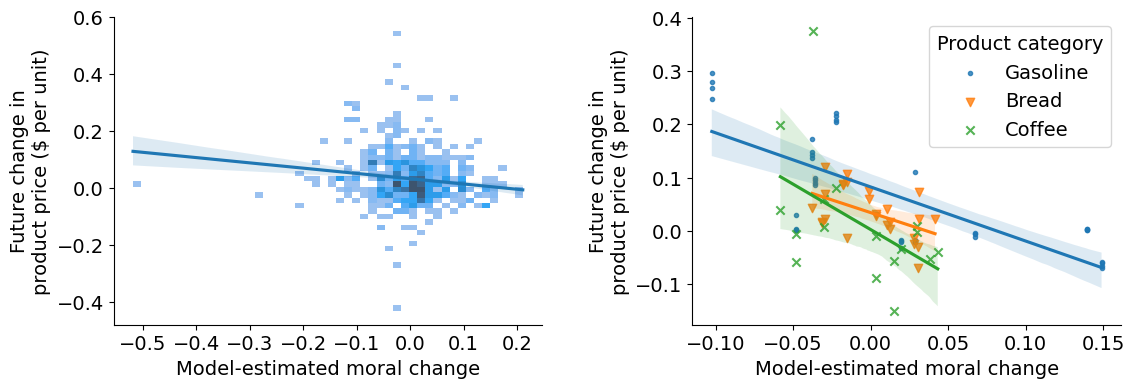

In [30]:

fig, axes = plt.subplots(1,2, figsize = (13, 4),sharex = False, sharey = False)
ax = axes[0]

plt.subplots_adjust( wspace=0.35)


sns.histplot(data = plot_df,
             x = 'moral_change_polarity', y = 'value_change' ,ax= ax,
               
               )

sns.regplot(data = plot_df,
             x = 'moral_change_polarity', y = 'value_change' ,ax = ax,scatter = False)
ax.set_ylabel('Future change in\nproduct price ($ per unit)',fontsize = 14)
ax.set_xlabel('Model-estimated moral change',fontsize = 14)
r,p = pearsonr(plot_df.moral_change_polarity,plot_df.value_change)

ax.set_xticklabels(ax.get_xticklabels(),fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)

ax = axes[1]
words = ['gasoline','bread','coffee']
sns.regplot(data = plot_df.loc[plot_df.words ==words[0]],
             x = 'moral_change_polarity',
             y = 'value_change',
             color = 'tab:blue',
            marker = '.',
               label = 'Gasoline' ,
             ax = ax,
           )


sns.regplot(data = plot_df.loc[plot_df.words ==words[1]],
             x = 'moral_change_polarity',
             y = 'value_change',
             color = 'tab:orange',
           label = 'Bread' ,
            marker = 'v',
             ax = ax)
sns.regplot(data = plot_df.loc[plot_df.words ==words[2]],
             x = 'moral_change_polarity',
             y = 'value_change',
             color = 'tab:green',
            marker = 'x',
           label = 'Coffee' ,
             ax = ax)
ax.set_ylabel('Future change in\nproduct price ($ per unit)',fontsize = 14)
ax.set_xlabel('Model-estimated moral change',fontsize = 14)
ax.legend(title = 'Product category',fontsize = 14,title_fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)

sns.despine()
# plt.savefig('notebooks/figs/nyt_cpi.png',dpi = 500, bbox_inches = 'tight')
# plt.savefig('notebooks/figs/nyt_cpi.pdf',dpi = 500, bbox_inches = 'tight')
plt.show()

### In the rest of the notebook, we try to predict changes in product prices based on the changes in their moral association scores and sentiment scores. 

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error


In [35]:
#Only keeping the products with at least 10 observations throughout 1987-2007 to avoid outliers

category_counts = plot_df.groupby('Item').year.count().to_dict()
mixed_df = plot_df.copy(deep = True)

mixed_df['category_count'] = mixed_df.Item.apply(lambda c : category_counts[c])
mixed_df = mixed_df.loc[mixed_df['category_count'] >= 10]


In [36]:
len(mixed_df.Item.unique()) #33 products in total

31

In [37]:
#normalization of the dataframe 
mixed_df['value_1'] = (mixed_df['value_1'] -  mixed_df['value_1'].mean()) / mixed_df['value_1'].std()
mixed_df['value_2'] = (mixed_df['value_2'] -  mixed_df['value_2'].mean()) / mixed_df['value_2'].std()
mixed_df['value_change'] = (mixed_df['value_change'] -  mixed_df['value_change'].mean()) / mixed_df['value_change'].std()
mixed_df['moral_change_polarity'] = (mixed_df['moral_change_polarity'] -  mixed_df['moral_change_polarity'].mean()) / mixed_df['moral_change_polarity'].std()


In [38]:
mixed_df.sample(2)

,words,year,Item,Series ID,value_change,value_1,value_2,count_2,count_1,sentiments_1,...,outputs_z_2_relevance,outputs_z_1_relevance,moral_change_relevance,property_polarity,outputs_z_2_polarity,outputs_z_1_polarity,moral_change_polarity,sentiment_change,category_count,year_norm
710,grape,1993,"Grapes, Thompson Seedless, per lb. (453.6 gm)",APU0000711417,1.254313,-0.396332,-0.262744,657.0,640.0,0.189382,...,-1.313347,-1.335308,0.021961,polarity,0.434783,0.469432,-0.635991,0.006730,11,-0.866571
143,beef,1997,"Ground beef, 100% beef, per lb. (453.6 gm)",APU0000703112,-0.086391,-0.320733,-0.325476,1232.0,1576.0,0.034833,...,0.507361,0.428435,0.078926,polarity,0.357434,0.262645,1.492608,0.177661,11,-0.160633


### Model 1: predicting $\Delta$ price based on price (t - 1) + year + product id

In [39]:
model1 = smf.ols("value_change ~ value_1 + C(Item) + year", mixed_df).fit()  
r2 = r2_score(mixed_df.value_change,model1.predict(mixed_df))
print(r2)

print("Random effect:")
print('MSE:', mean_squared_error(mixed_df.value_change, model1.predict(mixed_df)))
print(model1.summary())

0.14214938386339748
Random effect:
MSE: 0.8552822011182295
                            OLS Regression Results                            
Dep. Variable:           value_change   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.559
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0316
Time:                        07:23:10   Log-Likelihood:                -447.82
No. Observations:                 334   AIC:                             961.6
Df Residuals:                     301   BIC:                             1087.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------

### Model 2: predicting $\Delta$ price based on price (t - 1) + year + product id + $\Delta$ moral polarity 

As shown below, the effect of $\Delta$ moral polarity on $\Delta$ price is significant with p-value < 0.05, with a negative coefficient. This means that the more negative the moral polarity becomes, the more likely the price will increase and the more positive the moral polarity becomes, the more likely the price will decrease. 

In [40]:
model2 = smf.ols("value_change ~ moral_change_polarity + year_norm + C(Item) + value_1", mixed_df).fit()  
r2 = r2_score(mixed_df.value_change,model2.predict(mixed_df))
print(r2)

print("Random effect:")
print('MSE:', mean_squared_error(mixed_df.value_change, model2.predict(mixed_df)))
print(model2.summary())

0.17257305785126908
Random effect:
MSE: 0.8249496159746329
                            OLS Regression Results                            
Dep. Variable:           value_change   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1.896
Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00299
Time:                        07:23:54   Log-Likelihood:                -441.79
No. Observations:                 334   AIC:                             951.6
Df Residuals:                     300   BIC:                             1081.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------

# Model 3: predicting $\Delta$ price based on price (t - 1) + year + product id + $\Delta$ moral polarity + $\Delta$ sentiment. 

As shown below, the effect of $\Delta$ sentiment on $\Delta$ price is not significant in the presence of $\Delta$ moral polarity (p-value = 0.098). This means that the effect of $\Delta$ sentiment on $\Delta$ price is not significant when we control for the effect of $\Delta$ moral polarity. But the effect of $\Delta$ moral polarity on $\Delta$ price is still significant with p-value < 0.05, with a negative coefficient. 

This suggests that there's not enough evidence to conclude that the effect of $\Delta$ sentiment on $\Delta$ price is significant when we control for the effect of $\Delta$ moral polarity.
The moral framing of the product might be a more predictive factor for price changes than the general sentiment of the product.

In [43]:
model3 = smf.ols("value_change ~ moral_change_polarity + year_norm + C(Item) + value_1 + sentiment_change", mixed_df).fit()  
r2 = r2_score(mixed_df.value_change,model3.predict(mixed_df))
print(r2)

print("Random effect:")
print('MSE:', mean_squared_error(mixed_df.value_change, model3.predict(mixed_df)))
print(model3.summary())

0.18014169511692046
Random effect:
MSE: 0.8174036392995973
                            OLS Regression Results                            
Dep. Variable:           value_change   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     1.932
Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00207
Time:                        07:33:17   Log-Likelihood:                -440.25
No. Observations:                 334   AIC:                             950.5
Df Residuals:                     299   BIC:                             1084.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------

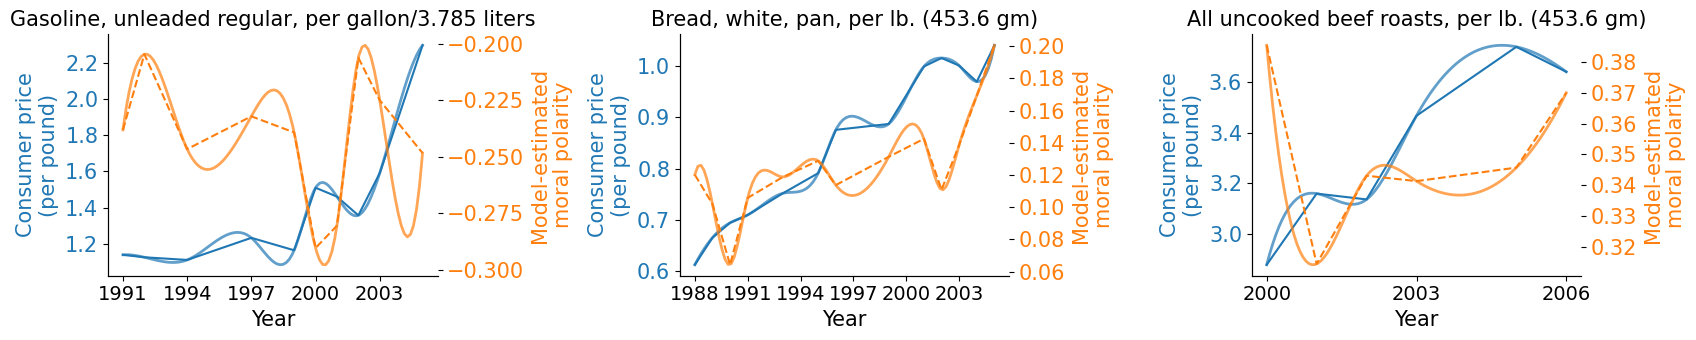

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import UnivariateSpline
import pandas as pd

items = ['Gasoline, unleaded regular, per gallon/3.785 liters','Bread, white, pan, per lb. (453.6 gm)','All Uncooked Beef Roasts, per lb. (453.6 gm)']
fig, axes = plt.subplots(1, len(items), figsize=(17, 3.5),sharey = False)

for i, w in enumerate(items):
    ax = axes[i]
    
    # Filter data for the word
    plotting_words = plot_df[plot_df.Item == w]
    
    # Primary y-axis: value_change
    sns.lineplot(data=plotting_words, x='year', y='value_2',
                 hue='words', errorbar=None, ax=ax, color='tab:blue')
    
    
    # Smooth line for value_change
    x = plotting_words.groupby('year').value_2.mean().reset_index().year
    y = plotting_words.groupby('year').value_2.mean().reset_index().value_2
    spl = UnivariateSpline(x, y, k=3, s=0)
    xs = np.linspace(x.min(), x.max(), 100)
    ax.plot(xs, spl(xs), 'tab:blue', lw=2, alpha=0.7)
    
    # Secondary y-axis: moral_change_polarity
    ax2 = ax.twinx()
    sns.lineplot(data=plotting_words, x='year', y='outputs_z_2_polarity',
                 linestyle='--', color='tab:orange', ax=ax2)
    
    
    # Smooth line for moral_change_polarity
    x = plotting_words.groupby('year').outputs_z_2_polarity.mean().reset_index().year
    y = plotting_words.groupby('year').outputs_z_2_polarity.mean().reset_index().outputs_z_2_polarity
    spl = UnivariateSpline(x, y, k=3, s=0)
    xs = np.linspace(x.min(), x.max(), 100)
    ax2.plot(xs, spl(xs), 'tab:orange', lw=2, alpha=0.7)
    
    # Add labels and titles
    ax.set_xlabel('Year', fontsize = 15)
    if i == 0:
        ax.set_ylabel('Consumer price\n(per pound)',color = 'tab:blue',fontsize = 15)
    else:
        ax.set_ylabel('Consumer price\n(per pound)',color = 'tab:blue',fontsize = 15)

    if i == 1:
        ax2.set_ylabel('Model-estimated\nmoral polarity',color ='tab:orange',fontsize = 15)
    else:
        ax2.set_ylabel('Model-estimated\nmoral polarity',color ='tab:orange',fontsize = 15)
    
    ax.set_title(w.capitalize(),fontsize = 15)
    
    # Adjust tick parameters and legends
    ax.set_xticks(np.arange(plotting_words.year.min(), plotting_words.year.max() + 1, 3))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14)
    ax.set_yticklabels(ax.get_yticklabels(), color = 'tab:blue',fontsize = 15)
    
    ax2.set_xticks(np.arange(plotting_words.year.min(), plotting_words.year.max() + 1, 3))
    ax2.set_yticklabels(ax2.get_yticklabels(), color = 'tab:orange',fontsize = 15)
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize = 15)
    
    ax.legend_ = None
    sns.despine()
    # ax2.despine(right=True)

plt.tight_layout()
# plt.savefig('notebook/figs/nyt_cpi_timeseries.pdf',dpi = 500, bbox_inches = 'tight')
# plt.savefig('notebook/figs/nyt_cpi_timeseries.png',dpi = 500, bbox_inches = 'tight')
plt.show()
